In [1]:
import numpy as np 
import pandas as pd 
import re
import itertools
import collections 
import nltk
import string
import unidecode
import random
import torch

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
df=pd.read_csv("../input/articles1.csv")
df = df.iloc[:1000,:]
dictionary = list(df.content)
def joinStrings(dictionary):
    return ' '.join(string for string in dictionary)

dictionary = joinStrings(dictionary)

In [4]:
stop = set(nltk.corpus.stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = nltk.stem.wordnet.WordNetLemmatizer()
def clean(doc):
        stop_free = " ".join([i for i in doc.split() if i not in stop])
        punc_free = "".join(ch for ch in stop_free if ch not in exclude)
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        return normalized
dictionary = clean(dictionary).lower()

In [5]:
all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(dictionary)
file_len = len(file)
print('file_len =', file_len)

file_len = 4778956


In [6]:
chunk_len = 10000

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]



In [7]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [8]:

# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


In [9]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

In [10]:
# def sample_temperature(x, temperature=1.0):
#     x = x.reshape(-1).astype(np.float)
#     x /= temperature
#     x = np.exp(x)
#     x /= np.sum(x)
#     x = random_state.multinomial(1, x)
#     x = np.argmax(x)
#     return x.astype(np.int64)


def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        # Alternative: use numpy
        #top_i = sample_temperature(output.data.numpy(), temperature)
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

In [11]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [12]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [13]:

n_epochs = 300
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.015

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0
inp,label=random_training_set()
for epoch in range(1, n_epochs + 1):
    loss = train(inp,label)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 50, loss))
        print(evaluate('ge', 200), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 40s (100 16%) 1.1325]
gend "the real prolita i family gay dealuside chuld month " sexuch colfrees said " auned boy scout pony bont palucarces comphoutly colled sundance said truniting show ffoos retive gether fore's deated c 

 21s (200 33%) 0.8173]
ge" series sexully esperned boy scouts don't nomplation produciming in musevery scous wermake done't whole director avan contentsion in st liew huly whelies meeting work life corganizad he were's felay  

 1s (300 50%) 0.5554]
ge "little the mber specificance roamity prate virgely without live go wholage "any meeting mainged inte said automaker project loath votm "hellion student towing incouram sad it shot west many youth hu 



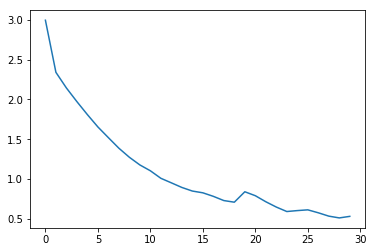

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [15]:
print(evaluate('your', 200, temperature=0.8))

yourshold caree gay membership officisicion decision mos refrieng mimberger said expecter houing eneter uber ship ope autonomous deall "there nuly coruim mr simien indice president enos -- wanker boy scou


In [16]:
print(evaluate('Th', 200, temperature=0.6))

The con's " said heral production get houraseling declined starned mark coluest enrous morting u " 2015 "little accidents" winding "i the ms realic show plast ohe dame gay week allow transgender decitio


In [17]:
print(evaluate('Th', 200, temperature=0.6))

Th'y hsin st she family enandinast cautomaker production you week scout several identity spring scout "the project she acclaimed 2017 "that probably harde like the film sopped spection nu" said autout h
